## Mask RCNN Setup

In [ ]:
!git clone https://github.com/tensorflow/tpu/

Cloning into 'tpu'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 9919 (delta 62), reused 64 (delta 35), pack-reused 9798
Receiving objects: 100% (9919/9919), 24.33 MiB | 30.31 MiB/s, done.
Resolving deltas: 100% (7100/7100), done.


In [3]:
from IPython import display
from PIL import Image
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils

In [ ]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

## Test Image

In [ ]:
image_path = 'beagle.jpg'

with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])
  
image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))

## Connect to TPU

In [ ]:
use_tpu = True
if use_tpu:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

TPU address is grpc://10.99.89.250:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 13858800221387204546),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1037498608298758754),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 14825545961195881687),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 13471579956140121643),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 971997337507195349),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 13298275962776591408),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 6880228866055626953),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 7190942915479704838),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 2002699872638

## Setup Pre-trained Model

In [ ]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850'
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

NameError: ignored

## Image Segmentation & Prediction

In [ ]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

## Visualize

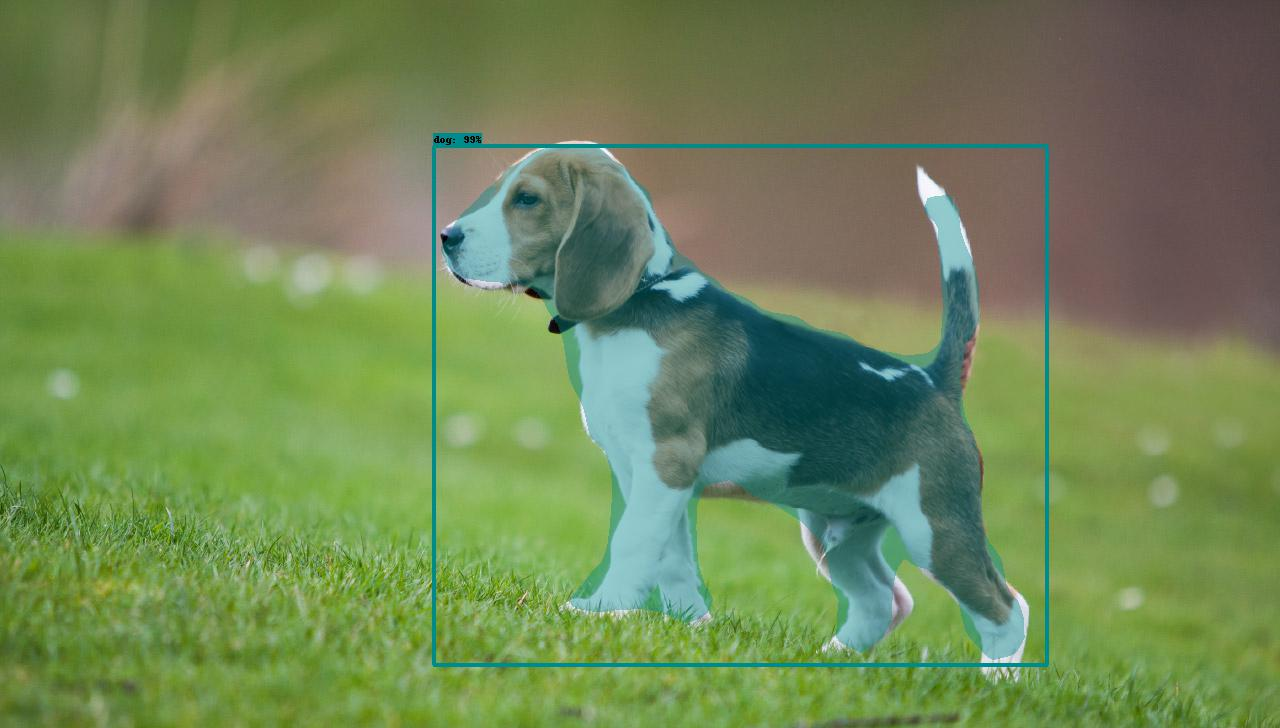

In [ ]:
max_boxes_to_draw = 50
min_score_thresh = 0.09

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))

## End to End Model

In [1]:
!rm -r /content/tpu
!git clone https://github.com/tensorflow/tpu/

rm: cannot remove '/content/tpu': No such file or directory
Cloning into 'tpu'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 9919 (delta 62), reused 64 (delta 35), pack-reused 9798
Receiving objects: 100% (9919/9919), 24.33 MiB | 36.64 MiB/s, done.
Resolving deltas: 100% (7100/7100), done.


In [2]:
from IPython import display as Idisplay
import PIL
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils

def Setup(use_tpu=True):
  # Load Coco Labels
  ID_MAPPING = {
    1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane',
    6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light',
    11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter',
    15: 'bench',  16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse',
    20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra',
    25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag',
    32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis',
    36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat',
    40: 'baseball glove', 41: 'skateboard', 42: 'surfboard',
    43: 'tennis racket',44: 'bottle',
    46: 'wine glass',47: 'cup',48: 'fork',49: 'knife',50: 'spoon',51: 'bowl',
    52: 'banana',53: 'apple',54: 'sandwich',55: 'orange',56: 'broccoli',
    57: 'carrot',58: 'hot dog',59: 'pizza',60: 'donut',61: 'cake',
    62: 'chair',63: 'couch',64: 'potted plant',65: 'bed',67: 'dining table',
    70: 'toilet',72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote',
    76: 'keyboard',77: 'cell phone',78: 'microwave',79: 'oven', 80: 'toaster',
    81: 'sink',82: 'refrigerator', 84: 'book', 85: 'clock', 86: 'vase',
    87: 'scissors', 88: 'teddy bear', 89: 'hair drier',90: 'toothbrush',
  }
  category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

  # Load TPUs
  if use_tpu:
    import os
    import pprint

    assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
    TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    print('TPU address is', TPU_ADDRESS)

    session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
    print('TPU devices:')
    pprint.pprint(session.list_devices())
  else:
    session = tf.Session(graph=tf.Graph())

  # Load Model
  saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850'
  _ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

  return(session, category_index)

def ConvertImageNP(image_path):

  with open(image_path, 'rb') as f:
    np_image_string = np.array([f.read()])
    
  image = PIL.Image.open(image_path)
  width, height = image.size
  np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)
  
  return (np_image, np_image_string, width, height)

def PredictImage(np_image, np_image_string, session, width, height):
  num_detections, detection_boxes, detection_classes, detection_scores, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

  num_detections = np.squeeze(num_detections.astype(np.int16), axis=(0,))
  detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
  detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
  detection_classes = np.squeeze(detection_classes.astype(np.int16), axis=(0,))[0:num_detections]
  # instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
  # ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
  # processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
  segmentations = None #coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

  return [detection_boxes, detection_classes, detection_scores, segmentations]

def VisualizeResults(np_image,
                     detection_boxes,
                     detection_classes,
                     detection_scores,
                     category_index,
                     segmentations,
                     max_boxes_to_draw = 50,
                     min_score_thresh=0.09,):

  image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
      np_image,
      detection_boxes,
      detection_classes,
      detection_scores,
      category_index,
      instance_masks=segmentations,
      use_normalized_coordinates=False,
      max_boxes_to_draw=max_boxes_to_draw,
      min_score_thresh=min_score_thresh)
  # output_image_path = 'test_results.jpg'
  output_image_path = PIL.Image.fromarray(image_with_detections.astype(np.uint8))
  # display.display(display.Image(output_image_path, width=1024)) 
  Idisplay.display(output_image_path)

# Main

session, category_index = Setup(use_tpu=True)
# np_image, np_image_string, width, height = ConvertImageNP("/content/beagle.jpg")
# prediction_results = PredictImage(np_image, np_image_string, session, width, height)
# prediction_results.insert(3,category_index)
# VisualizeResults(np_image,*prediction_results)


TensorFlow 1.x selected.
TPU address is grpc://10.87.34.170:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 13892449070924576733),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 880654053989420072),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 7543595568777676913),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 17462848244598810108),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 14511905043749584422),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 11984585202324914991),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 10965458708150783895),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 16039253204989679887),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU,

## Live Video/Webcam Prediction

## Webcam/Video Stream Helpers

In [4]:
from IPython.display import display, Javascript, Image, clear_output
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [5]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream(width, height):
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    var width = 480;
    var height = 320;
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, width, height);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = width; //video.videoWidth;
      captureCanvas.height = height; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [6]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  return (data, binary)

## Real-time Live Detection

In [ ]:
import time
from io import BytesIO
from urllib.parse import urlparse
# start streaming video from webcam
width = 480
height = 320
video_stream(width, height)
# time.sleep(3)
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
current_time = time.time()
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([height, width, 4] ,dtype=np.uint8)

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    count += 1
    if (time.time() - current_time > 0.39):
      # clear_output(wait=True)
      image_bytes = b64decode(js_reply["img"].split(",")[1])
      np_image_string = np.array([image_bytes])
      frame = cv2.resize(frame,(int(height/3), int(width/3)))
      # current_time = time.time()
      prediction_results = PredictImage(frame, np_image_string, session, int(width/3), int(height/3))
      # print(time.time() - current_time)
      prediction_results.insert(3,category_index)
      # VisualizeResults(frame,*prediction_results,max_boxes_to_draw=10, min_score_thresh=0.7)
    else:
      # print(time.time() - current_time)
      # clear_output(wait=True)
      output_image_path = PIL.Image.fromarray(frame.astype(np.uint8))
      # display.display(display.Image(output_image_path, width=1024)) 
      # Idisplay.display(output_image_path)

    if (prediction_results and len(prediction_results) > 0):
      # bbox_array = np.zeros([240, 320, 4] ,dtype=np.uint8)
      detection_boxes = prediction_results[0]
      detection_classes = prediction_results[1]
      detection_scores = prediction_results[2]
      
      for i in range(detection_boxes.shape[0]):
        
        if (detection_scores[i] < 0.8):
          continue
        bbox_array = cv2.rectangle(bbox_array,
                                   (int(detection_boxes[i][1]), int(detection_boxes[i][0])),
                                   (int(detection_boxes[i][3]), int(detection_boxes[i][2])),
                                   (255,10,10), 3)
        bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(category_index[detection_classes[i]]["name"],
                                                                  detection_scores[i]),
                          (int(detection_boxes[i][1]), int(detection_boxes[i][0] - 10)), cv2.FONT_HERSHEY_PLAIN, 1,
                          (255,10,10),1)
      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
      bbox_bytes = bbox_to_bytes(bbox_array)
      bbox =  bbox_bytes

<IPython.core.display.Javascript object>

## Pre-recorded Video Detection

In [ ]:
!wget https://www.sample-videos.com/video123/mp4/720/big_buck_bunny_720p_5mb.mp4

In [7]:
# ~3gb
!wget -O car_driving.tar https://www.dropbox.com/s/lxunx184vnvg1tj/2014-08-11-10-49-42_stereo_centre_01.tar?dl=0
# Edit to handle proper unzipping
!mkdir /content/car_driving
!tar -xf car_driving.tar -C /content/car_driving/
glob_path = "/content/car_driving/2014-08-11-10-49-42/stereo/centre/*.png" 

--2021-04-09 01:55:09--  https://www.dropbox.com/s/lxunx184vnvg1tj/2014-08-11-10-49-42_stereo_centre_01.tar?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/lxunx184vnvg1tj/2014-08-11-10-49-42_stereo_centre_01.tar [following]
--2021-04-09 01:55:09--  https://www.dropbox.com/s/raw/lxunx184vnvg1tj/2014-08-11-10-49-42_stereo_centre_01.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd75160f6b0f856568f1b6c2cbc.dl.dropboxusercontent.com/cd/0/inline/BMRiIJ-JKNUsybGaVO_o3RHmWzjNcf0_IdAf6oaSpkbWG0_0UDYpR_zyuijFJbPQ1l9RxnBfpszUHRlZn-QKWdcLLHZheS-eJhwXKxlJLOvMDyZnmukMdXbdl3k9xCrWm_iIvSfL4_Oagl3RHjecFvIf/file# [following]
--2021-04-09 01:55:10--  https://ucd75160f6b0f856568f1b6c2cbc.dl.dropboxusercontent.com/cd/0/inline/B

In [ ]:
# ~100mb
!wget -O sample_driving.tar https://www.dropbox.com/s/yozwgjtdhfy53hz/sample_small.tar?dl=0
# Edit to handle proper unzipping
!mkdir /content/car_driving
!tar -xf sample_driving.tar -C /content/car_driving/
glob_path = "content/car_driving/stereo/centre/*.png"

In [8]:
# Turn Directory into Generator
import glob
image_paths = [file for file in glob.glob(glob_path)]
image_paths = sorted(image_paths)
# print(image_paths)
imagesl = [cv2.imread(file) for file in image_paths]
print(type(imagesl))

<class 'list'>


In [9]:
!mkdir /content/processed_images

In [21]:
images = iter(imagesl)

In [33]:
from IPython.display import clear_output, Image
import base64
from google.colab.patches import cv2_imshow
import time
import numpy as np
import cv2

video = cv2.VideoWriter("/content/OxfordPredicton.avi", 0, 15, (320,240))
# video_capture = cv2.VideoCapture('big_buck_bunny_720p_5mb.mp4')
# vidcap = cv2.VideoCapture("/content/drive/MyDrive/Intelligent Systems/IMG_4653.MOV")
# success,image = vidcap.read()

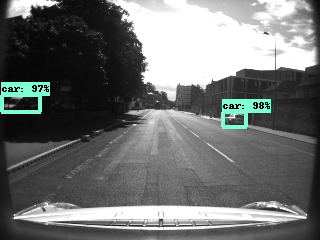

In [34]:
# def arrayShow (imageArray):
#     ret, png = cv2.imencode('.png', imageArray)
#     encoded = base64.b64encode(png)
#     return Image(data=encoded.decode('ascii'))

current_time = time.time()
counter = 0;
frame = [1]
while counter < 345: #len(frame) > 0:
    frame = next(images, [])
    if (time.time() - current_time > 0):
      if (len(frame) == 0):
        break

      frame = cv2.resize(frame, (320, 240))
      clear_output(wait=True)
      image_bytes = cv2.imencode('.jpg', frame)[1].tostring()
      np_image_string = np.array([image_bytes])
      prediction_results = PredictImage(frame, np_image_string, session, 320, 240)
      prediction_results.insert(3,category_index)
      VisualizeResults(frame,*prediction_results, max_boxes_to_draw=20, min_score_thresh=0.7)
      # img = arrayShow(frame)
      # display(img)
      # if (prediction_results and len(prediction_results) > 0):
      #   # bbox_array = np.zeros([240, 320, 4] ,dtype=np.uint8)
      #   detection_boxes = prediction_results[0]
      #   detection_classes = prediction_results[1]
      #   detection_scores = prediction_results[2]
        
      #   for i in range(detection_boxes.shape[0]):
          
      #     if (detection_scores[i] < 0.8):
      #       continue
      #     cv2.rectangle(frame,
      #                   (int(detection_boxes[i][1]), int(detection_boxes[i][0])),
      #                   (int(detection_boxes[i][3]), int(detection_boxes[i][2])),
      #                   (255,10,10), 3)
      #     cv2.putText(frame, "{} [{:.2f}]".format(category_index[detection_classes[i]]["name"],
      #                   detection_scores[i]),
      #                   (int(detection_boxes[i][1]), int(detection_boxes[i][0] - 10)), cv2.FONT_HERSHEY_PLAIN, 1,
      #                   (255,10,10),1)
      # cv2.imwrite("/content/processed_images/frame{}.jpg".format(counter),frame)
      video.write(frame)
      counter += 1
      # cv2_imshow(frame)
      current_time = time.time()
    # else:
      # frame = cv2.resize(frame, (320, 240))
      # clear_output(wait=True)
      # output_image_path = PIL.Image.fromarray(frame.astype(np.uint8))
      # # display.display(display.Image(output_image_path, width=1024)) 
      # Idisplay.display(output_image_path)


cv2.destroyAllWindows()
video.release()

In [ ]:
# Visualize detected objects with after nms
cloned_img = img.copy()
for class_label in nms_labels:
  for (box, prob) in nms_labels[class_label]:
    (x, y, x2, y2) = box
    color = [random.randint(0,255), random.randint(0,255), random.randint(0,255)]
    cv2.rectangle(cloned_img, (x, y), (x2, y2), color, 2)
    text_offset = y - 10 if y - 10 > 10 else y + 10
    cv2.putText(cloned_img, str(class_label), (x, text_offset),fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=2, color=color, thickness=2)

plt.imshow(cloned_img)

In [ ]:
# Convert Frames to Video
video = cv2.VideoWriter(video_name, 0, 1, (width,height))